Importing modules

In [42]:
%pip install pandas
%pip install matplotlib

# Save requirements.txt
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

Setting up data prep variables

In [4]:
year_col = "Quarter_Year"
index_suff = "_HPI"
price_suff = "_Standardised_Price"

price_min = 0
index_min = 0

q_year_regex = r"^Q[1-4]\s\d{4}$"

Parse Quarter_Year strings into Year (int), Quarter (int), Period_end (datetime)

In [5]:
def parse_quarter_year(qy: pd.Series) -> pd.DataFrame:
    qy = qy.astype("string").str.strip()

    bad = ~qy.str.match(q_year_regex, na=False)
    if bad.any():
        examples = qy[bad].dropna().unique()[:10]
        raise ValueError(f"Quarter_Year contains invalid values, examples: {examples}")
    
    quarter = qy.str.extract(r"^Q([1-4])\s(\d{4})$")[0].astype(int)
    year = qy.str.extract(r"^Q([1-4])\s(\d{4})$")[1].astype(int)

    q_end_month = quarter.map({1: 3, 2: 6, 3: 9, 4: 12})
    period_end = pd.to_datetime(
        dict(year=year, month=q_end_month, day=1)
    ) + pd.offsets.MonthEnd(0)

    return pd.DataFrame({"Year": year, "Quarter": quarter, "Period_End": period_end})

Convert wide dataset to long, converting format from:
"Quarter_Year", "Belfast_HPI", "Belfast_Standardised_Price" ... into:
Quarter_Year, LGD, HPI, Standardised_Price

In [6]:
def wide_to_long_lgd(df: pd.DataFrame) -> pd.DataFrame:
    if year_col not in df.columns:
        raise KeyError(f"Missing required column: {year_col}")
    
    # Identify LGD columns by suffix
    index_cols = [c for c in df.columns if c.endswith(index_suff)]
    price_cols = [c for c in df.columns if c.endswith(price_suff)]

    if not index_cols and not price_cols:
        raise ValueError("No LGD HPI/Price columns found. Check suffixes / column names.")
    
    # Determine LGD names by removing suffix
    lgds_from_index = {c[: -len(index_suff)] for c in index_cols}
    lgds_from_price = {c[: -len(price_suff)] for c in price_cols}
    lgds = sorted(lgds_from_index.union(lgds_from_price))

    # Build long records
    long_frame = []
    for lgd in lgds:
        cols = [year_col]
        index_col = f"{lgd}{index_suff}"
        price_col = f"{lgd}{price_suff}"

        tmp = df[[year_col]].copy()
        tmp["LGD"] = lgd
        
        tmp["HPI"] = df[index_col] if index_col in df.columns else np.nan
        tmp["Standardised_Price"] = df[price_col] if price_col in df.columns else np.nan

        long_frame.append(tmp)

    out = pd.concat(long_frame, ignore_index=True)

    # Drop any completely NULL rows
    out = out.dropna(subset=["HPI", "Standardised_Price"], how="all")

    return out

Enforce data types, convert Quarter_Year into multiple columns and apply cleaning

In [7]:
def enforce_types_and_clean(df_long: pd.DataFrame) -> pd.DataFrame:
    # Clean strings of whitespace
    df_long[year_col] = df_long[year_col].astype("string").str.strip()
    df_long["LGD"] = df_long["LGD"].astype("string").str.strip()

    # Parse time
    time_df = parse_quarter_year(df_long[year_col])
    df_long = pd.concat([df_long.reset_index(drop=True), time_df], axis=1)

    # Ensure Index and Price are numeric
    df_long["HPI"] = pd.to_numeric(df_long["HPI"], errors="coerce")
    df_long["Standardised_Price"] = pd.to_numeric(df_long["Standardised_Price"], errors="coerce")

    # Enforce expected datatypes
    df_long["Year"] = df_long["Year"].astype("int64")
    df_long["Quarter"] = df_long["Quarter"].astype("int64")
    df_long["LGD"] = df_long["LGD"].astype("category")

    # Number range checking (log errors)
    bad_price = (df_long["Standardised_Price"].notna()) & (df_long["Standardised_Price"] <= price_min)
    bad_index = (df_long["HPI"].notna()) & (df_long["HPI"] <= index_min)

    if bad_price.any():
        sample = df_long.loc[bad_price, ["LGD", year_col, "Standardised_Price"]].head(10)
        raise ValueError(f"Found impossible Standardised_Price values (sample):\n{sample}")
    
    if bad_index.any():
        sample = df_long.loc[bad_index, ["LGD", year_col, "HPI"]].head(10)
        raise ValueError(f"Found impossible HPI values (sample):\n{sample}")
    
    # Sort for time
    df_long = df_long.sort_values(["LGD", "Period_End"]).reset_index(drop=True)

    return df_long

Validate time and duplicates for LGDs

In [8]:
def validate_time_series(df_long: pd.DataFrame) -> None:
    # Check for duplicate LGD x Quarter_Year
    dup = df_long.duplicated(subset=["LGD", year_col])
    if dup.any():
        sample = df_long.loc[dup, ["LGD", year_col]].head(10)
        raise ValueError(f"Duplicate LGD x Quarter_Year rows found (sample):\n{sample}")
    
    # Check for any missing quarters per LGD
    for lgd, g in df_long.groupby("LGD", observed=True):
        g = g.sort_values("Period_End")
        diffs = g["Period_End"].diff().dropna()
        p = g["Period_End"].dt.to_period("Q")
        if not (p[1:].reset_index(drop=True) == (p.shift(1)[1:].reset_index(drop=True) + 1)).all():
            missing_info = pd.DataFrame({"LGD": [lgd], "note": ["Non-consecutive quarters detected"]})
            raise ValueError(f"Time continuity issue for {lgd}. {missing_info.to_string(index=False)}")

Add lagged features per LGD for future forecasting

In [9]:
def add_lag_features(df_long: pd.DataFrame, lags=(1,)) -> pd.DataFrame:
    df = df_long.copy()
    for lag in lags:
        df[f"Price_lag_{lag}"] = df.groupby("LGD", observed=True)["Standardised_Price"].shift(lag)
        df[f"HPI_lag_{lag}"] = df.groupby("LGD", observed=True)["HPI"].shift(lag)
    return df

Main combined data cleaning/prepping pipeline:
wide to long, parse time, enforce datatypes, validate and add lag features

In [10]:
def clean_lgd_dataset(df_raw: pd.DataFrame) -> pd.DataFrame:
    long_df = wide_to_long_lgd(df_raw)
    long_df = enforce_types_and_clean(long_df)
    validate_time_series(long_df)

    long_df = add_lag_features(long_df, lags=(1,))

    return long_df

Bring in raw data

In [36]:
csv_path = Path("../Project/Data/standardised-price-and-index-by-lgd-q1-2005-q2-2025.csv")
csv_path.parent.mkdir(parents=True, exist_ok=True)

df_raw = pd.read_csv(csv_path)

df_raw.head()

,Quarter_Year,Antrim_and_Newtownabbey_HPI,Antrim_and_Newtownabbey_Standardised_Price,Ards_and_North_Down_HPI,Ards_and_North_Down_Standardised_Price,Armagh_City_Banbridge_and_Craigavon_HPI,Armagh_City_Banbridge_and_Craigavon_Standardised_Price,Belfast_HPI,Belfast_Standardised_Price,Causeway_Coast_and_Glens_HPI,...,Fermanagh_and_Omagh_HPI,Fermanagh_and_Omagh_Standardised_Price,Lisburn_and_Castlereagh_HPI,Lisburn_and_Castlereagh_Standardised_Price,Mid_and_East_Antrim_HPI,Mid_and_East_Antrim_Standardised_Price,Mid_Ulster_HPI,Mid_Ulster_Standardised_Price,Newry_Mourne_and_Down_HPI,Newry_Mourne_and_Down_Standardised_Price
0,Q1 2005,64.757496,107490.977137,68.035173,123662.111857,65.161339,99340.285628,66.578100,99461.799366,61.758582,...,66.315555,104020.362605,63.465388,123086.740895,66.148047,97052.531074,70.370037,108034.687663,62.377440,108230.240612
1,Q2 2005,64.640971,107297.556283,70.586997,128300.360502,67.761688,103304.590567,67.078251,100208.980689,64.111471,...,71.048889,111444.912578,66.247250,128481.969414,67.569325,99137.831870,75.625814,116103.551806,69.279663,120206.194262
2,Q3 2005,69.967466,116139.007059,71.548867,130048.673876,70.107196,106880.382611,73.096557,109199.798043,69.259431,...,76.297142,119677.145886,70.608063,136939.466963,72.942191,107020.911488,80.564993,123686.361607,72.540480,125863.992852
3,Q4 2005,72.556285,120436.188420,74.510047,135430.975548,73.973592,112774.812669,73.839011,110308.958726,71.626217,...,79.255195,124317.049677,73.616850,142774.800173,74.129865,108763.467727,83.480973,128163.083083,76.495803,132726.819869
4,Q1 2006,73.567257,122114.300181,76.477755,139007.520955,77.643195,118369.224899,74.904865,111901.250958,74.544335,...,82.148565,128855.492292,73.108969,141789.801670,74.967587,109992.575653,88.751255,136254.214241,78.860427,136829.645099


Check info of raw data

In [23]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 23 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Quarter_Year                                            82 non-null     object 
 1   Antrim_and_Newtownabbey_HPI                             82 non-null     float64
 2   Antrim_and_Newtownabbey_Standardised_Price              82 non-null     float64
 3   Ards_and_North_Down_HPI                                 82 non-null     float64
 4   Ards_and_North_Down_Standardised_Price                  82 non-null     float64
 5   Armagh_City_Banbridge_and_Craigavon_HPI                 82 non-null     float64
 6   Armagh_City_Banbridge_and_Craigavon_Standardised_Price  82 non-null     float64
 7   Belfast_HPI                                             82 non-null     float64
 8   Belfast_Standardised_Price                

Clean the data using outlined pipeline above:

In [24]:
df_clean = clean_lgd_dataset(df_raw)

df_clean.head()

,Quarter_Year,LGD,HPI,Standardised_Price,Year,Quarter,Period_End,Price_lag_1,HPI_lag_1
0,Q1 2005,Antrim_and_Newtownabbey,64.757496,107490.977137,2005,1,2005-03-31,NaN,NaN
1,Q2 2005,Antrim_and_Newtownabbey,64.640971,107297.556283,2005,2,2005-06-30,107490.977137,64.757496
2,Q3 2005,Antrim_and_Newtownabbey,69.967466,116139.007059,2005,3,2005-09-30,107297.556283,64.640971
3,Q4 2005,Antrim_and_Newtownabbey,72.556285,120436.188420,2005,4,2005-12-31,116139.007059,69.967466
4,Q1 2006,Antrim_and_Newtownabbey,73.567257,122114.300181,2006,1,2006-03-31,120436.188420,72.556285


Validate the cleaned data

In [25]:
df_clean.shape

(902, 9)

In [26]:
df_clean["LGD"].unique()

['Antrim_and_Newtownabbey', 'Ards_and_North_Down', 'Armagh_City_Banbridge_and_Craigavon', 'Belfast', 'Causeway_Coast_and_Glens', ..., 'Fermanagh_and_Omagh', 'Lisburn_and_Castlereagh', 'Mid_Ulster', 'Mid_and_East_Antrim', 'Newry_Mourne_and_Down']
Length: 11
Categories (11, string): [Antrim_and_Newtownabbey, Ards_and_North_Down, Armagh_City_Banbridge_and_Craigavon, Belfast, ..., Lisburn_and_Castlereagh, Mid_Ulster, Mid_and_East_Antrim, Newry_Mourne_and_Down]

In [27]:
df_clean.sort_values(["LGD", "Period_End"]).head(10)

,Quarter_Year,LGD,HPI,Standardised_Price,Year,Quarter,Period_End,Price_lag_1,HPI_lag_1
0,Q1 2005,Antrim_and_Newtownabbey,64.757496,107490.977137,2005,1,2005-03-31,NaN,NaN
1,Q2 2005,Antrim_and_Newtownabbey,64.640971,107297.556283,2005,2,2005-06-30,107490.977137,64.757496
2,Q3 2005,Antrim_and_Newtownabbey,69.967466,116139.007059,2005,3,2005-09-30,107297.556283,64.640971
3,Q4 2005,Antrim_and_Newtownabbey,72.556285,120436.188420,2005,4,2005-12-31,116139.007059,69.967466
4,Q1 2006,Antrim_and_Newtownabbey,73.567257,122114.300181,2006,1,2006-03-31,120436.188420,72.556285
5,Q2 2006,Antrim_and_Newtownabbey,80.542801,133693.007124,2006,2,2006-06-30,122114.300181,73.567257
6,Q3 2006,Antrim_and_Newtownabbey,90.421114,150090.019599,2006,3,2006-09-30,133693.007124,80.542801
7,Q4 2006,Antrim_and_Newtownabbey,101.804214,168984.829760,2006,4,2006-12-31,150090.019599,90.421114
8,Q1 2007,Antrim_and_Newtownabbey,112.205316,186249.620682,2007,1,2007-03-31,168984.829760,101.804214
9,Q2 2007,Antrim_and_Newtownabbey,123.056350,204261.253465,2007,2,2007-06-30,186249.620682,112.205316


In [28]:
df_clean.isna().sum()

Quarter_Year           0
LGD                    0
HPI                    0
Standardised_Price     0
Year                   0
Quarter                0
Period_End             0
Price_lag_1           11
HPI_lag_1             11
dtype: int64

We expect 11 NULL values in both lag columns as there are 11 LGDs, and the first entry to each LGD will not have a previous value to fill this NULL

Save the cleaned dataset as a seperate file:

In [35]:
output_path = Path("..\Project\Data\processed/LGD_house_prices_clean.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)
print(output_path.resolve())

df_clean.to_csv(output_path, index=False)

H:\Work\BelfastMET\Course\DSDE\Coursework 1\DSDE-CW1\Project\Data\processed\LGD_house_prices_clean.csv


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Nbeat\AppData\Local\Temp\ipykernel_23048\2386873836.py:1: SyntaxWarning: invalid escape sequence '\P'
  output_path = Path("..\Project\Data\processed/LGD_house_prices_clean.csv")


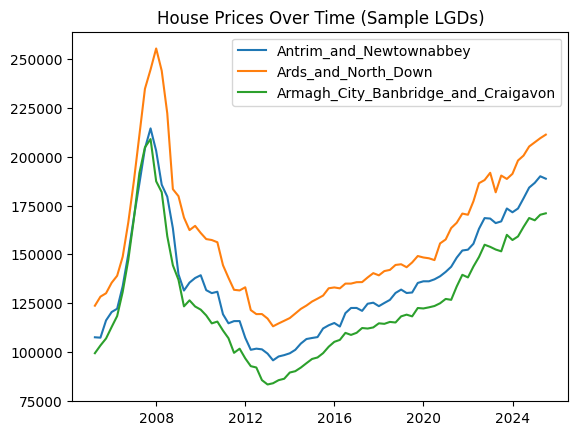

In [40]:
import matplotlib.pyplot as plt

for lgd in df_clean["LGD"].cat.categories[:3]:
    subset = df_clean[df_clean["LGD"] == lgd]
    plt.plot(subset["Period_End"], subset["Standardised_Price"], label=lgd)

plt.legend()
plt.title("House Prices Over Time (Sample LGDs)")
plt.show()